# Exercise 18

## Analyze class homeworks


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import spacy
#https://www.youtube.com/watch?v=mCJ3wzjiNvA
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from unicodedata import normalize
from wordcloud import WordCloud,STOPWORDS
import string
from nltk import wordpunct_tokenize
from sklearn.model_selection import train_test_split
df = pd.read_excel('E18.xlsx')
df.head()

,Sexo,T1,T2,T3,T4,T5,T6
0,H,Un científico de datos y un ingeniero de datos...,NaN,Los árboles de decisión es uno de los algoritm...,NaN,"En el documento ""Do We Need Hundreds of Classi...",Boosting builds models from individual so call...
1,H,Aunque los dos perfiles cuentan con habilidade...,Aunque el conceso no es total en el tema de ma...,NaN,En Machine Learing el propósito de los métodos...,El paper publicado en 2014 hace una evaluación...,Gradient Boosting ClassifierGradient Boosting ...
2,H,Python vs Stata. Analizar información es un pr...,En el marco del Machine Learning encontramos c...,Árbol de clasificación Como su nombre lo indic...,Este es un mecanismo que utiliza varios algori...,El paper analiza 179 clasificadores de 17 dife...,Gradient Boosting Classifier busca aprender de...
3,M,Los algoritmos de machine learning buscan pred...,Los algoritmos de machine learning buscan pred...,Los arboles de decisión pertenecen a los algor...,Consideremos el siguiente ejemplo: Una persona...,¿Se necesitan cientos de modelos para resolver...,NaN
4,H,Python vs R para análisis de datos. A pesar de...,Tipos de aprendizaje en Machine Learning. El M...,Tipos de árboles de decisión y aplicaciones. U...,La combinación de modelos o ensemble es un mod...,En el articulo se analizan cerca de 180 clasif...,XGBoosting vs GBoosting. A pesar de que el alg...


# Exercise 18.1

Analyze the writing patterns of each student

In [5]:
print(df.groupby('Sexo').count())

      T1  T2  T3  T4  T5  T6
Sexo                        
H     33  25  23  28  27  25
M      8   5   7   8   8   4


In [6]:
for column in df.columns:
    df[column] = df[column].astype(str)
df['Sexo'] = df['Sexo'].map({'H':1,'M':0})
df['Text'] =  df[['T1', 'T2', 'T3', 'T4', 'T5']].apply(lambda x: ''.join(x), axis=1)
df['Len_Text'] = df['Text'].apply(len)
df.describe()

,Sexo,Len_Text
count,42.000000,42.000000
mean,0.809524,8571.047619
std,0.397437,3481.420519
min,0.000000,1443.000000
25%,1.000000,6758.000000
50%,1.000000,8566.500000
75%,1.000000,9644.750000
max,1.000000,22077.000000


In [9]:
stop_words = set(stopwords.words('spanish'))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
df['Text'] = df['Text'].apply(lambda x: x.lower())
df['Text'] = df['Text'].apply(removeStopWords)
df['Text'] = df['Text'].astype(str)
df['Text'][3:8]

3     algoritmos  machine learning buscan predecir ...
4    python vs r  análisis  datos.  pesar   ambos l...
5    siendo dos grandes software's  analítica  dos ...
6    data scientist  data engineer  dos profesiones...
7     diferencias   científico  datos   ingeniero  ...
Name: Text, dtype: object

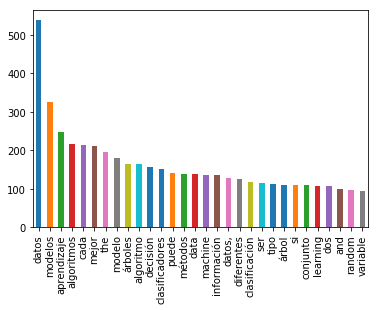

In [10]:
pd.Series(' '.join(df['Text']).split()).value_counts()[:30].plot(kind='bar')

In [13]:
stemmer = SnowballStemmer("spanish")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
df['Text'] = df['Text'].apply(stemming)
df.Text[3:8]

3    algoritm machin learning busc predec result en...
4    python vs r analisis datos. pes ambos lenguaj ...
5    siend dos grand software's analit dos gust per...
6    dat scientist dat engin dos profesion enmarc a...
7    diferent cientif dat ingeni dat radic responsa...
Name: Text, dtype: object

# Exercise 18.2

Evaluate the similarities of the homeworks of the students

tip: https://github.com/orsinium/textdistance

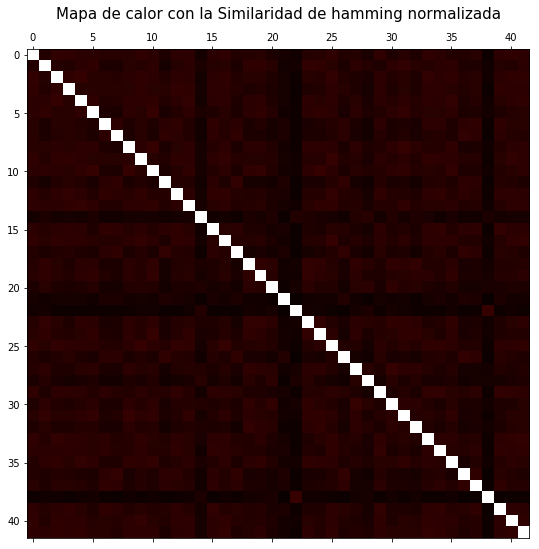

In [16]:
import textdistance
def similarity_ham(data):
    results = pd.DataFrame(0, index=data.index, columns=data.index)
    for i in range(len(data)):
        for j in range(len(data)):
            results.loc[i,j] = textdistance.hamming.normalized_similarity(data['Text'][i], data['Text'][j])
    assert results.shape == (data.shape[0], data.shape[0])
    return results
simil2 = similarity_ham(df)
fig = plt.figure(figsize = (9,9)) 
ax3 = fig.add_subplot(111)
ax3.matshow(simil2, cmap=plt.cm.hot, aspect='auto') 
ax3.set_title('Mapa de calor con la Similaridad de hamming normalizada', fontsize=15)
plt.show()

# Exercise 18.3

Create a classifier to predict the sex of each student



In [17]:
df.Text.head(3)
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
vect = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=1, max_df=0.4, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X_dtm = vect.fit_transform(df['Text'])
y = df.Sexo
x_train, x_test, y_train, y_test = train_test_split(X_dtm, y, test_size=0.3, random_state=42)

In [28]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
y_pred = clf.predict(x_test)

In [31]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92
